# Exploring Filecoin Deals 

Storage deals are core to Filecoin. They are the [main mechanism by which clients and storage providers interact](https://filecoin.io/blog/posts/how-storage-and-retrieval-deals-work-on-filecoin/). 

Let's explore the data!

## Data Sources

Deals data is available from the on-chain state (via the [`StateMarketDeals`](https://lotus.filecoin.io/reference/lotus/state/#statemarketdeals) JSON-RPC method). The state doesn't reflect the historical deals, but should be enough to get a sense of things.

Alternatively you can use an [oracle like `fil-naive-marketwatch`](https://github.com/ribasushi/fil-naive-marketwatch), rely on APIs like [Spacescope](https://spacescope.io/) for aggregated data or reconstruct the deals from [Lily](https://lilium.sh/) CSV dumps, which can provide all deals in Filecoin history.

I'll rely on [Glif nodes](https://lotus.filecoin.io/lotus/developers/glif-nodes/) export of `StateMarketDeals` on S3 ([direct link](https://marketdeals.s3.amazonaws.com/StateMarketDeals.json.zst)). 

In [1]:
%load_ext sql
%sql duckdb://

In [3]:
%%sql 

create table filecoin_state_market_deals as (
    select DealID, Proposal.*, State.* from read_ndjson_auto("/tmp/ParsedStateMarketDeals.json")
)

Running query in 'duckdb://'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Count
37938341


In [5]:
%%sql

select 
    sum(PieceSize) / 1024 ** 5 as total_pibs_in_active_deals,
from filecoin_state_market_deals
where SectorStartEpoch > 0

Running query in 'duckdb://'

total_pibs_in_active_deals
1134.5030589004118


In [10]:
%%sql sector_start_lag <<

select 
    DealID,
    StartEpoch,
    SectorStartEpoch,
    StartEpoch - SectorStartEpoch as SectorStartLag,
from filecoin_state_market_deals
where SectorStartEpoch > 0

Running query in 'duckdb://'

In [12]:
sector_start_lag = sector_start_lag.DataFrame()


count    3.654148e+07
mean     1.565833e+04
std      8.315649e+03
min      0.000000e+00
25%      1.259100e+04
50%      1.364800e+04
75%      1.800800e+04
max      2.580400e+05
Name: SectorStartLag, dtype: float64

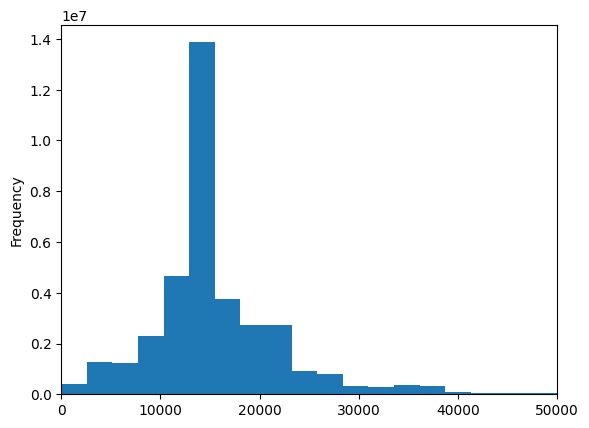

In [15]:
_ = sector_start_lag["SectorStartLag"].plot.hist(bins=100, xlim=(0, 50000))
sector_start_lag["SectorStartLag"].describe()


In [16]:
%%sql

select
    PieceCID."/" as piece_id,
    count(*) as copies
from state_market_deals
where 1=1
    and SectorStartEpoch != -1
    and SlashEpoch = -1
group by piece_id
having copies < 20
order by 2 desc

Running query in 'duckdb:////tmp/local.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

piece_id,copies
baga6ea4seaqbzgxi433tmkczbt3tjxuowtgui6hafo67o6m7buipfgt57m6k2na,19
baga6ea4seaqiybgaka5svssl52fgr3bmd4q7avateggi3vmqvyqier7mk4dfoka,19
baga6ea4seaqi57bpicf74ex6owzv35qympyiivsqc4hcdwa6kggtyalxnmdgkjy,19
baga6ea4seaqdw6vpp25o4dqfwksbmar2nbqszarvimtsbrt5ouim26su3o7bkhq,19
baga6ea4seaqfukeem5on3tcyunu6b5x7quaoxjrjtvty37tuhkek5nsrtebm2mi,19
baga6ea4seaqn5kiciwnjvtmm7w3gzldl6ywou3f7jks2fddye3gtozq5do6h2ni,19
baga6ea4seaqgwkt2pxqokbehxer73cnr25tstzjrrdiudtxu2wg2m6jj3yhi2fa,19
baga6ea4seaqfzrnztqwgjyu46hssvn3m7x6cqnvtsojmgcaohsc7fpzsxoc6kby,19
baga6ea4seaqfxgt5bhswek7ndiqzyikmv2b4ktom5tc6xgfjtr2isl7c773v2cq,19
baga6ea4seaqpmk5qeyh2rdiujco6knh4222ajxiry3oxpwwess2ade5klbhwqeq,19


In [17]:
%%sql

select
    PieceCID."/" as piece_id,
    count(*) as copies
from state_market_deals
where 1=1
    and SectorStartEpoch != -1
    and SlashEpoch = -1
group by piece_id
order by copies desc
limit 5

Running query in 'duckdb:////tmp/local.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

piece_id,copies
baga6ea4seaqof356aeq4mvurh43yir2z6j3wguczeke4dy4lngbb7fwrmfpjydy,10420
baga6ea4seaqnvexhndom5ipydpn42c3va2jhuepv4bc7rwrc33t3x7gqkn53ugi,8640
baga6ea4seaqma3d2foqh3obhlxca2z4emobsarysx5pyrygroakuyxyd7sjzmby,6518
baga6ea4seaqfecaafawnex4i4z3dlpv5ngaxp5sa5spgf77mz3s3lvfidqom2da,636
baga6ea4seaqootvvm3rolzm7o4cdbshrgs4ceoe5rdwi6j6q52gmmkgtppwiogq,631


In [19]:
%%sql

select distinct
    Client,
    Provider,
from state_market_deals
where PieceCID."/" = 'baga6ea4seaqof356aeq4mvurh43yir2z6j3wguczeke4dy4lngbb7fwrmfpjydy'

Running query in 'duckdb:////tmp/local.duckdb'

Client,Provider
f01624861,f01781851
f01624861,f01716466
